
# Pre-process 12-lead ECG signal
Stefan/Yuzhao Heng
Since Wed. Nov. 17th, 2021


Signals from different sources need to be de-noised & unified


## Setup



ic| dnm: 'INCART'
    sig: array([ -9.84824903,  -9.91828794,  -9.91634241, ..., -10.77237354,
                -10.76070039, -10.71011673])
    sig.shape: (462600,)


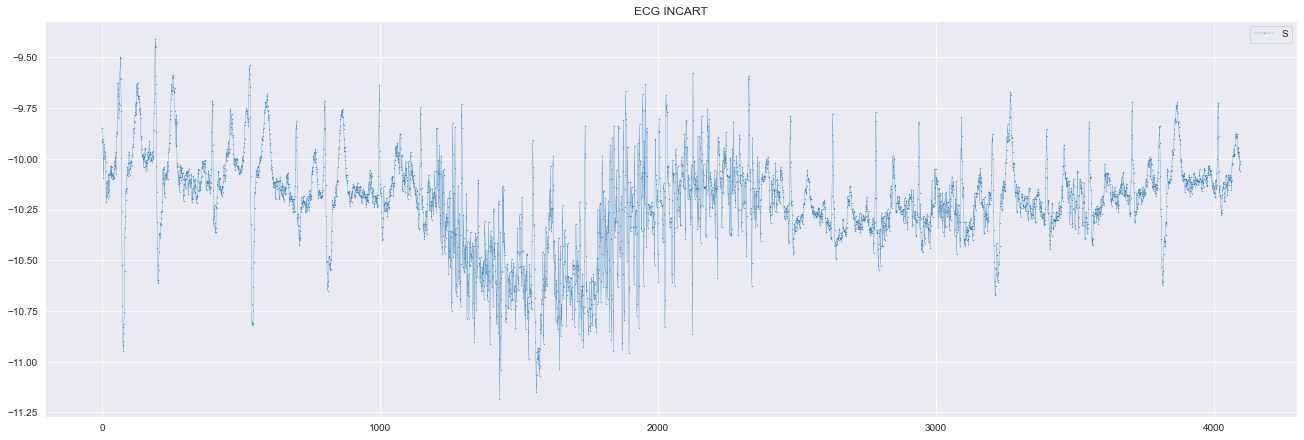

ic| dnm: 'PTB_XL'
    sig: array([-0.025, -0.025, -0.025, ...,  0.015,  0.015,  0.015])
    sig.shape: (5000,)


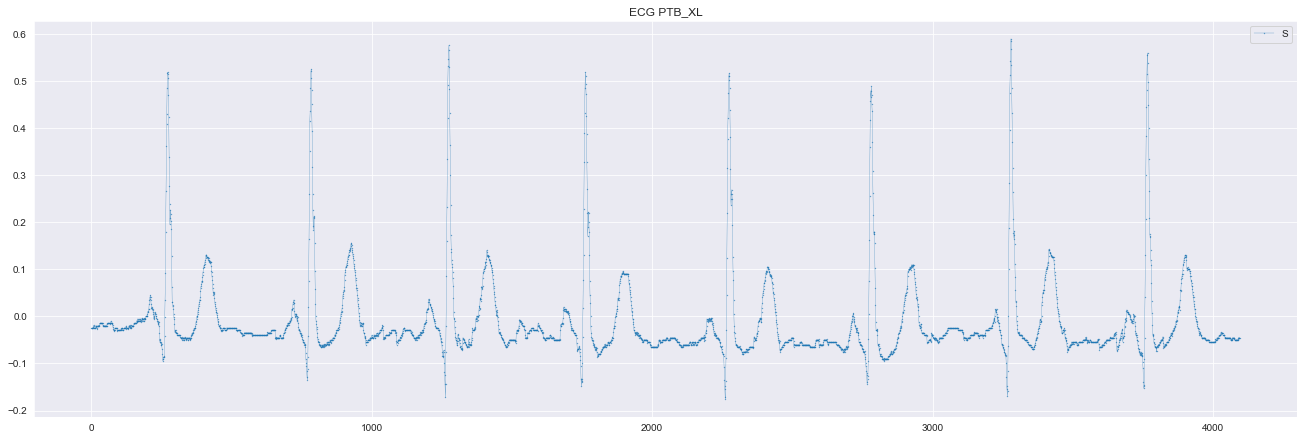

ic| dnm: 'PTB_Diagnostic'
    sig: array([-0.1035, -0.1005, -0.103 , ..., -0.1175, -0.1195, -0.114 ])
    sig.shape: (120012,)


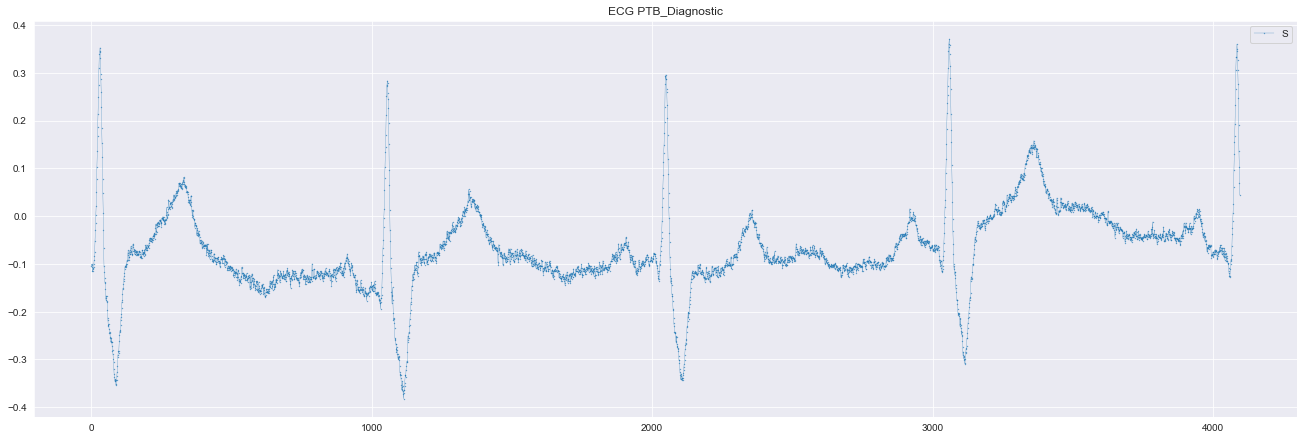

ic| dnm: 'CSPC_CinC'
    sig: array([-0.083, -0.117, -0.106, ..., -0.038, -0.036, -0.039])
    sig.shape: (5000,)


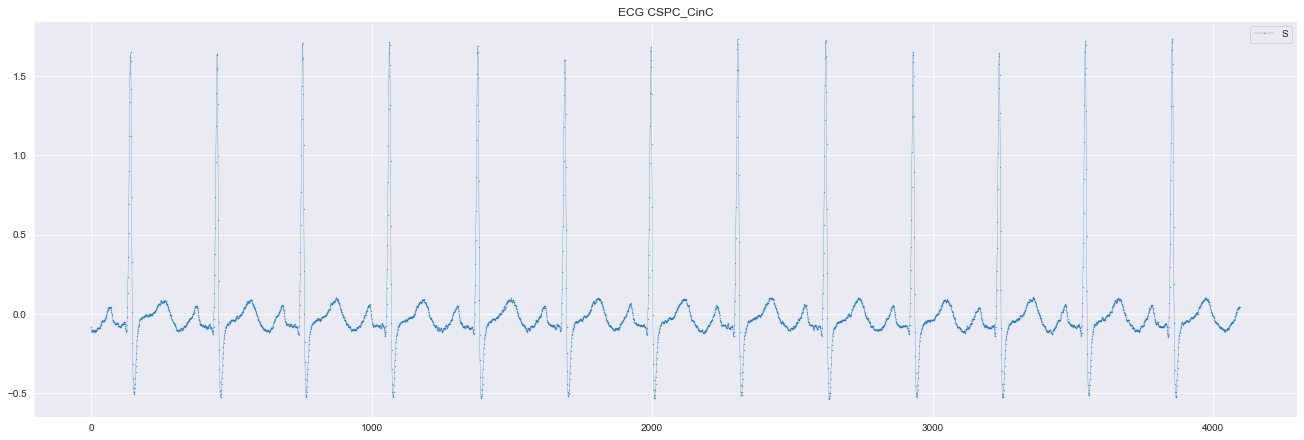

ic| dnm: 'CSPC_Extra_CinC'
    sig: array([-0.044, -0.031, -0.009, ...,  0.008,  0.007,  0.014])
    sig.shape: (11500,)


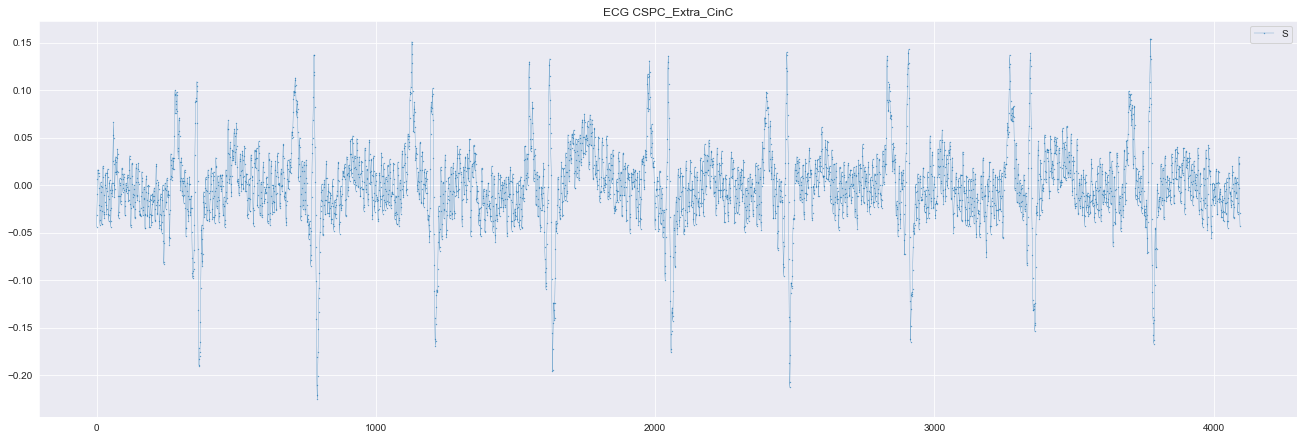

ic| dnm: 'G12EC'
    sig: array([-0.009, -0.009, -0.009, ...,  0.224,  0.273,  0.302])
    sig.shape: (5000,)


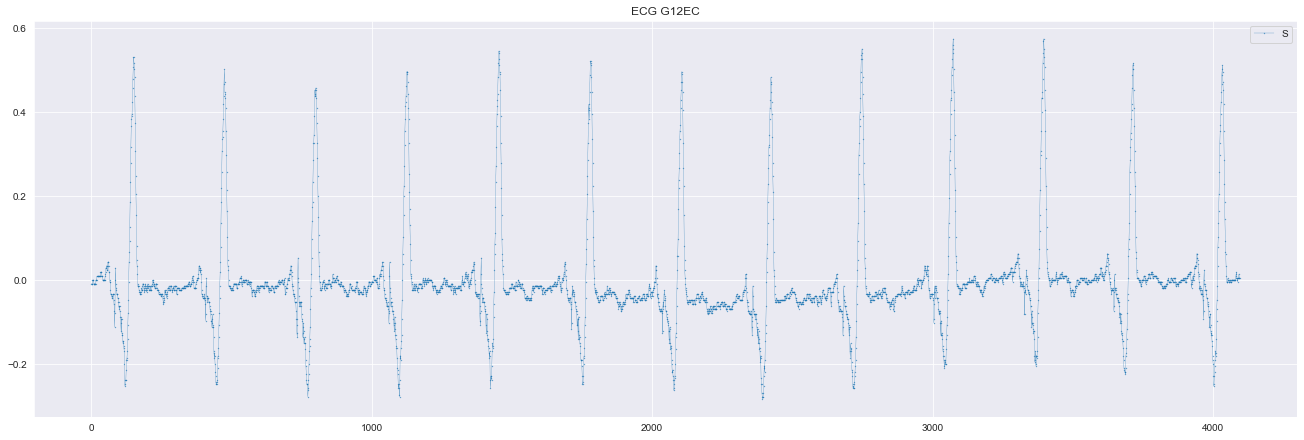

ic| dnm: 'CHAP_SHAO'
    sig: array([ -9.76, -19.52,  -9.76, ...,  14.64,  -4.88,   9.76])
    sig.shape: (5000,)


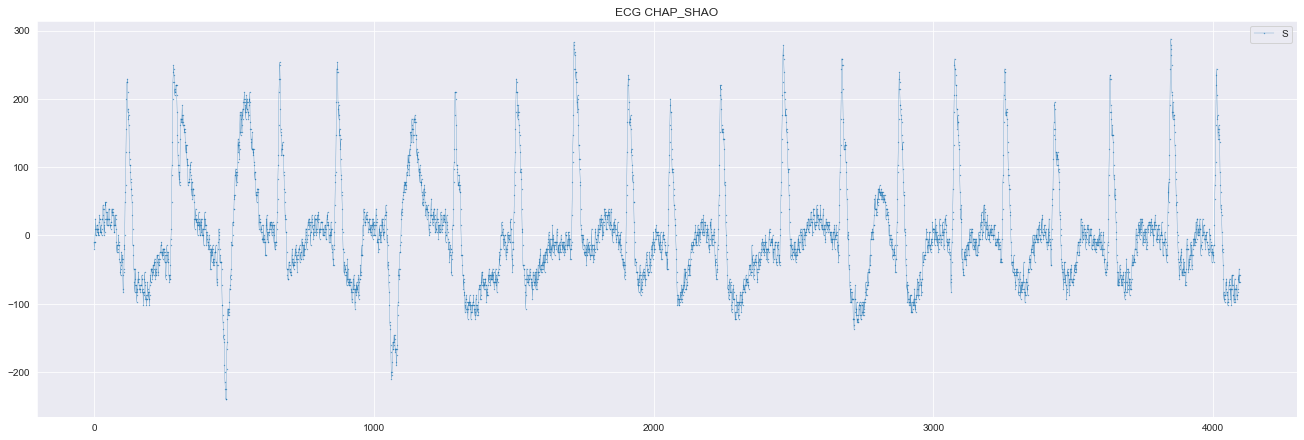

ic| dnm: 'CODE_TEST'
    sig: array([-0.96888648, -0.9746775 , -0.96799859, ..., -0.38833734,
                -0.38872384, -0.38226948])
    sig.shape: (4096,)


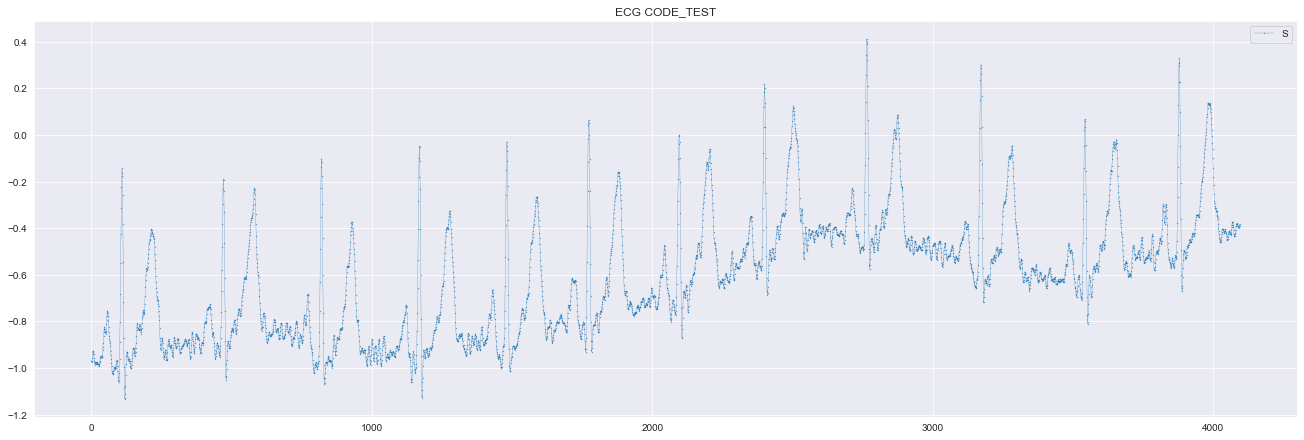

In [12]:
import math

import numpy as np
import pywt
import wfdb
from wfdb import processing
from icecream import ic

from util import *
from data_preprocessor import DataPreprocessor


np.random.seed(config('random_seed'))


d_sig = dict()
for dnm in config('datasets_export.total'):
    sig = d_sig[dnm] = get_signal_eg(dnm=dnm)[:, 0]  # Single lead
    ic(dnm, sig, sig.shape)
    plot_1d(sig[:2**12], label='Single lead', title=f'ECG {dnm}')

dp = DataPreprocessor()



## Some signals indicative of noise



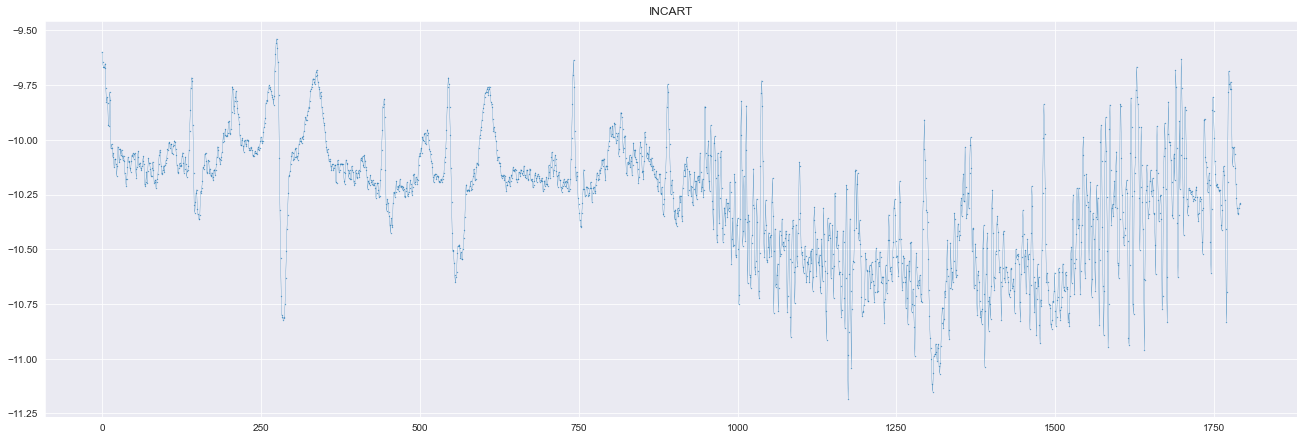

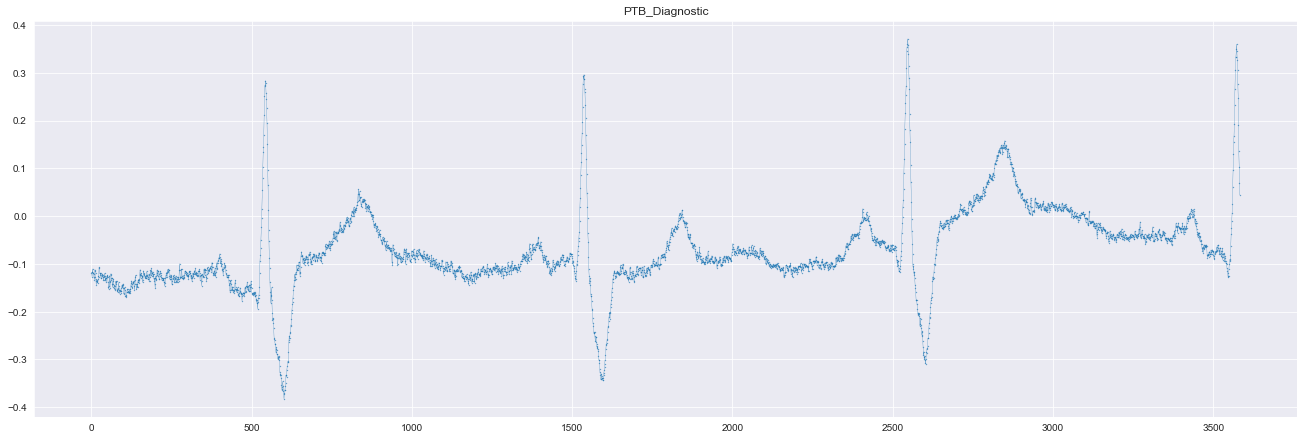

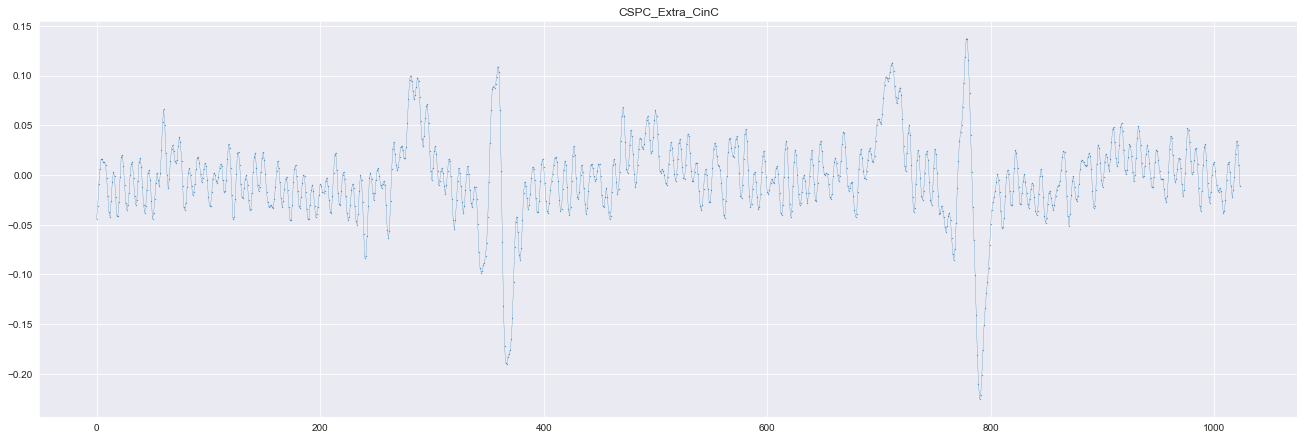

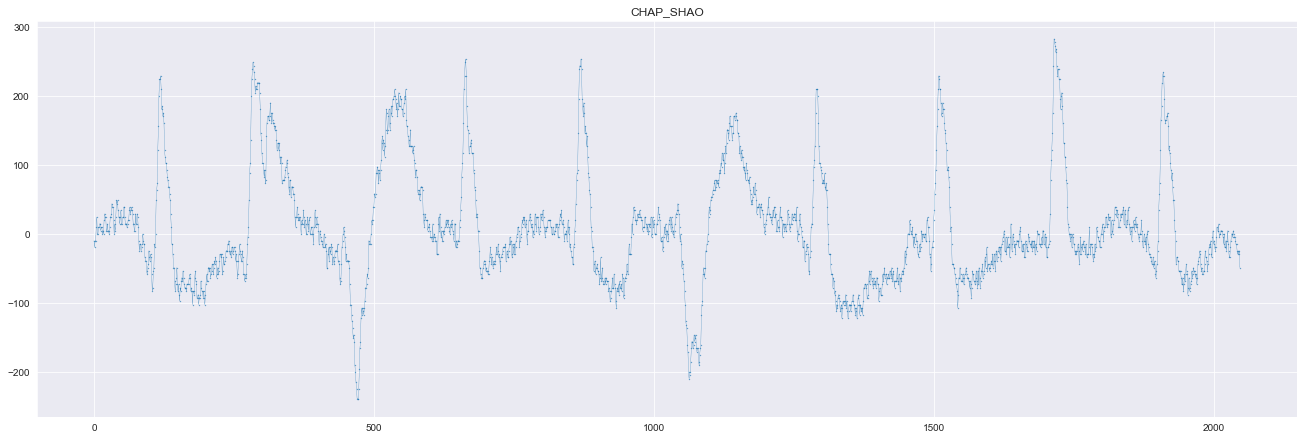

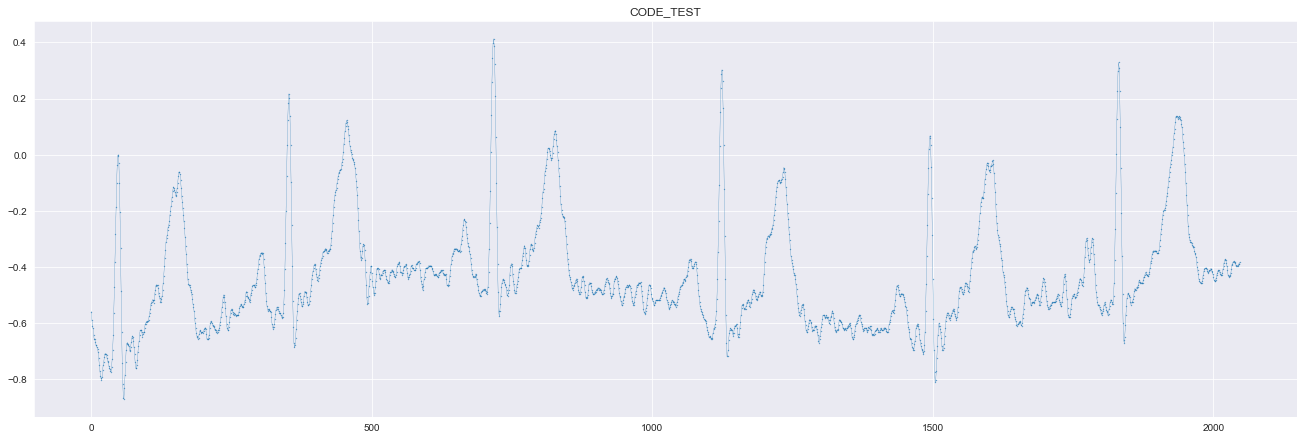

In [3]:
d_eg = {dnm: d_sig[dnm][s:e] for dnm, (s, e) in [
    ['INCART', (2**8,2**11)],
    ['PTB_Diagnostic', (2**9, 2**12)],
    ['CSPC_Extra_CinC', (0, 2**10)],
    ['CHAP_SHAO', (0, 2**11)],
    ['CODE_TEST', (2**11, 2**12)],
]}

for dnm, sig in d_eg.items():
    plot_1d(sig, title=dnm)



## Remove noise
### Wavelet thresholding
Which wavelet, which threshold, how many levels to decompose?

What's a good paper/resource on this?


ic| sig.max(): 0.137, sig.min(): -0.225


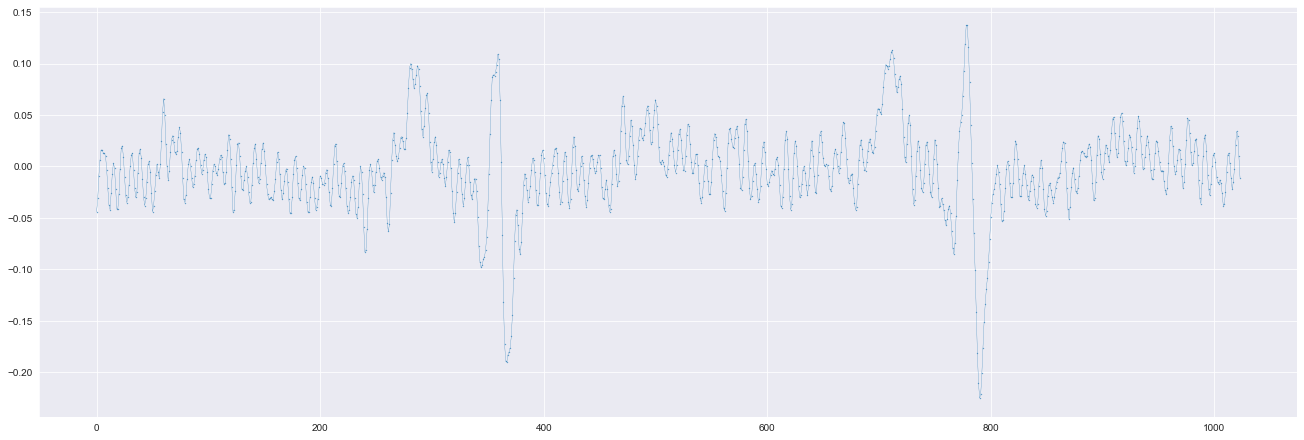

ic| pywt.dwt_max_level(l, w): 8, math.floor(math.log2(l)): 10
ic| threshold: 0.125
ic| list(map(lambda x: (x.min(), x.max()), coeffs)): [(-0.3329227936752994, 0.2563197329276882),
                                                      (-0.26335686126310387, 0.30693197159136515),
                                                      (-0.16240072951162546, 0.2933512643156962),
                                                      (-0.396423212120877, 0.4629480225244093),
                                                      (-0.12905197567807178, 0.1599650944920056),
                                                      (-0.051050948015713034, 0.05328059408747355),
                                                      (-0.013756396621779738, 0.018361881885183066)]


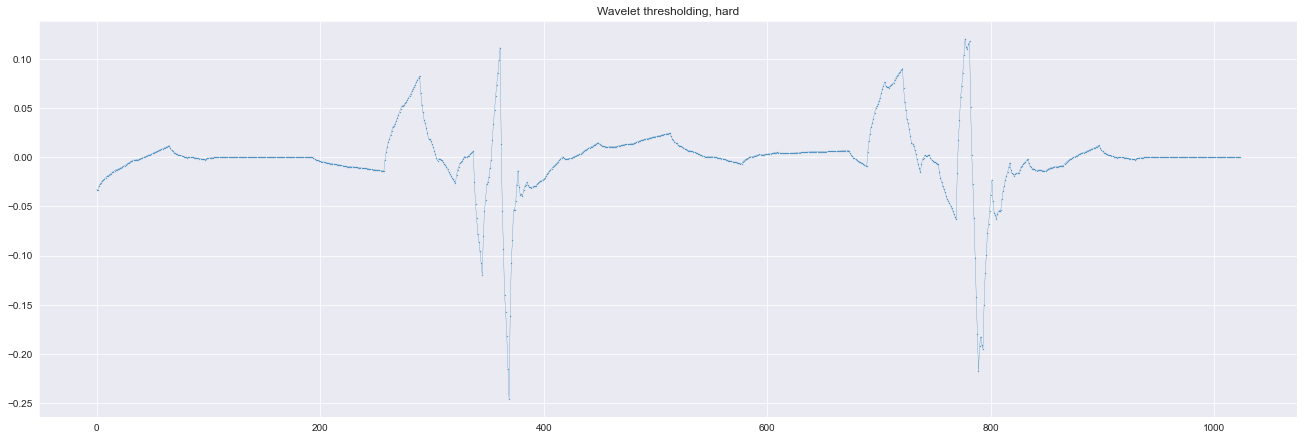

ic| list(map(lambda x: (x.min(), x.max()), coeffs)): [(-0.3329227936752994, 0.2563197329276882),
                                                      (-0.26335686126310387, 0.30693197159136515),
                                                      (-0.16240072951162546, 0.2933512643156962),
                                                      (-0.396423212120877, 0.4629480225244093),
                                                      (-0.12905197567807178, 0.1599650944920056),
                                                      (-0.051050948015713034, 0.05328059408747355),
                                                      (-0.013756396621779738, 0.018361881885183066)]


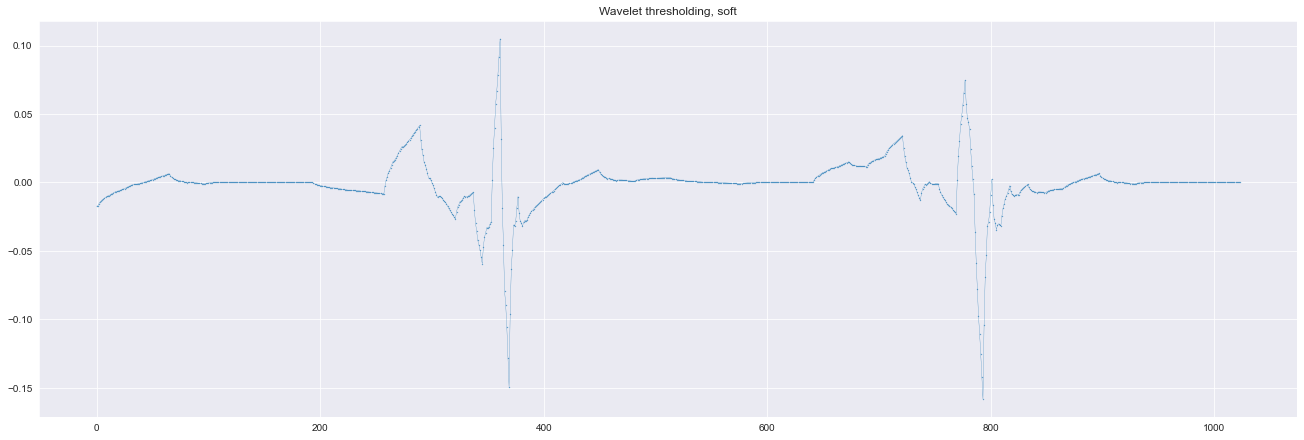

In [3]:
# sig = d_eg['CODE_TEST']
sig = d_eg['CSPC_Extra_CinC']
ic(sig.max(), sig.min())
plot_1d(sig)


# w = 'db2'
w = 'sym2'
l = sig.shape[0]
level = 6
ic(pywt.dwt_max_level(l, w), math.floor(math.log2(l)))

def wv_threshold(sig, t, w='db2', level=6, mode='soft'):
    coeffs = pywt.wavedec(sig, w, level=level)
    coeffs_ = list(map(lambda x: pywt.threshold(x, t, mode=mode), coeffs))
    # coeffs_ = list(map(lambda x: pywt.threshold(x, math.sqrt(2 * math.log2(x.size)), mode=mode), coeffs))
    ic(list(map(lambda x: (x.min(), x.max()), coeffs)))
    return pywt.waverec(coeffs_, w)


threshold = 1 / 2**3  # Arbitrary
ic(threshold)
plot_1d(wv_threshold(sig, threshold, level=level, mode='hard'), title='Wavelet thresholding, hard')
plot_1d(wv_threshold(sig, threshold, level=level, mode='soft'), title='Wavelet thresholding, soft')



### NLM
Used in the paper *Optimal Multi-Stage Arrhythmia Classification Approach*,
the authors contributed ECG dataset of 40k records, so I assume a credible source

Looks like the same approach is in the paper *A 12-lead electrocardiogram database for arrhythmia research covering more than 10,000 patients*,
by the same group of researchers


#### Check performance
The one that verified implementation


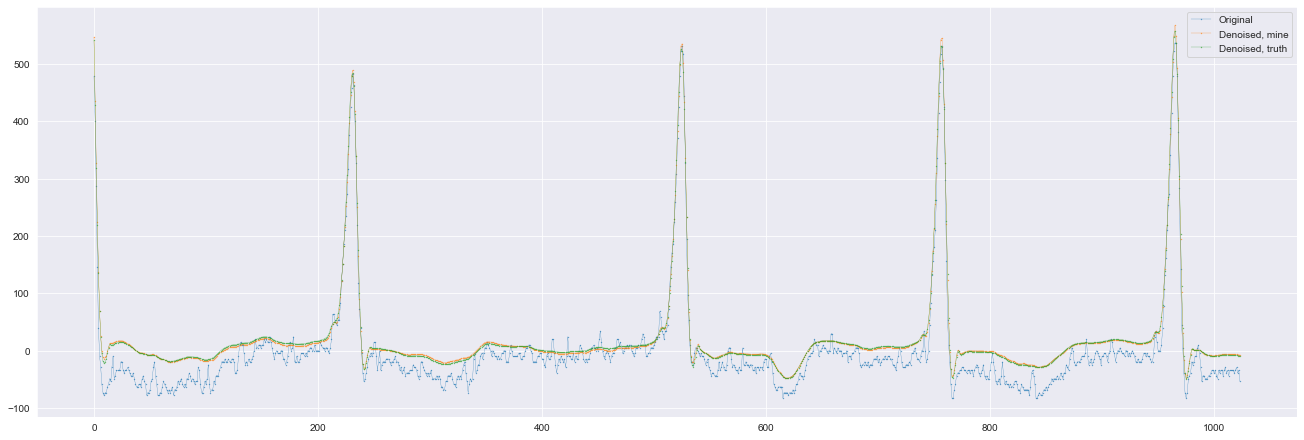

In [4]:
s, truth_denoised, truth_lowpass, truth_rloess, truth_localres, truth_after2nd = get_nlm_denoise_truth(verbose=False)
# plot_1d([s, truth_denoised], label=['Original', 'Denoised, truth'], e=2 ** 10)

denoised = dp.zheng(s)
# plot_1d([s, denoised], label=['Original', 'Denoised, mine'], e=2 ** 10)
plot_1d([s, denoised, truth_denoised], label=['Original', 'Denoised, mine', 'Denoised, truth'], e=2 ** 10)



On the same signal in the above
Note that `CSPC_Extra_CinC` has frequency of 500Hz, same as that of `CHAP_SHAO`

Seems like the NLM approach somehow shifts all data to around mean of 0?
It makes sense since subtracting the smoothed curve



ic| dnm: 'INCART'
    fqs: 257
    sig.mean(): -10.266459882226238
    denoised.mean(): 0.0040219767103938505


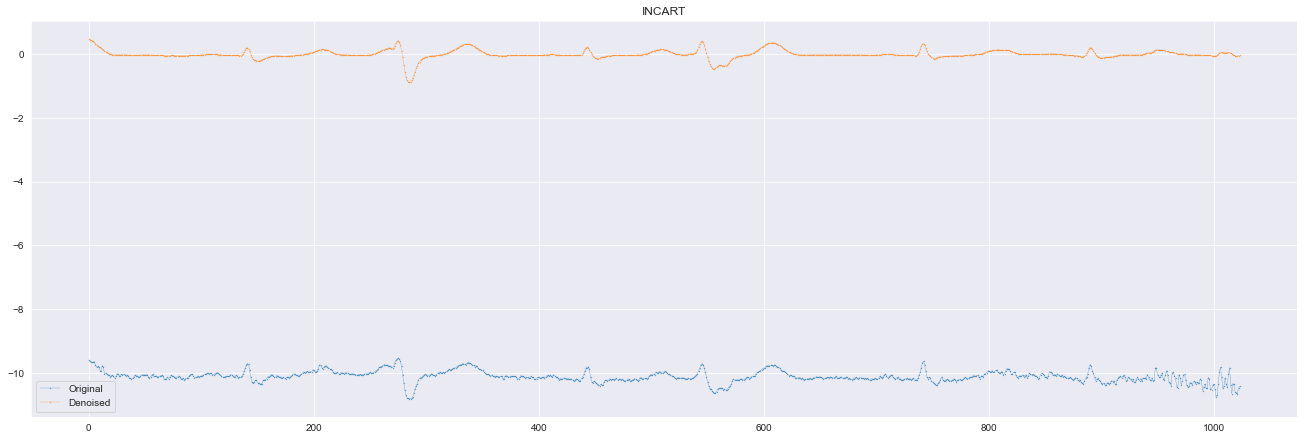

ic| dnm: 'PTB_Diagnostic'
    fqs: 1000
    sig.mean(): -0.07147265624999999
    denoised.mean(): 0.0013126864075761538


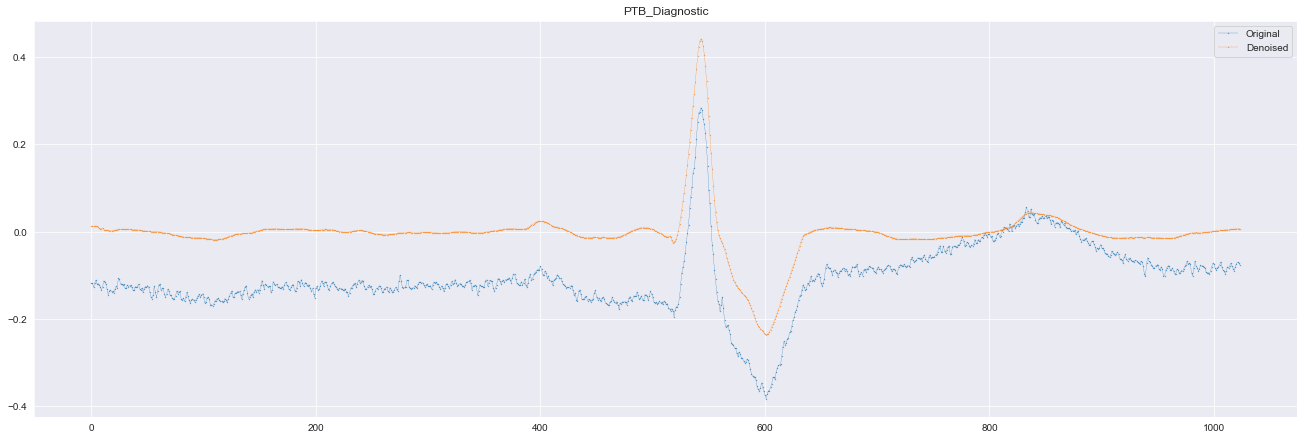

ic| dnm: 'CSPC_Extra_CinC'
    fqs: 500
    sig.mean(): -0.0033632812500000004
    denoised.mean(): 0.000584333894140088


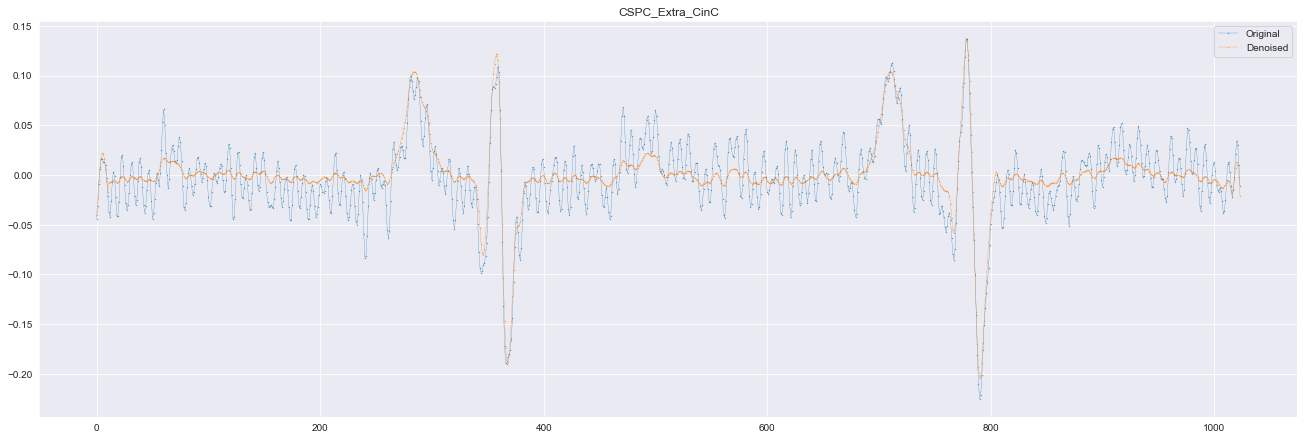

ic| dnm: 'CHAP_SHAO'
    fqs: 500
    sig.mean(): 7.6440625
    denoised.mean(): 9.236300654930778


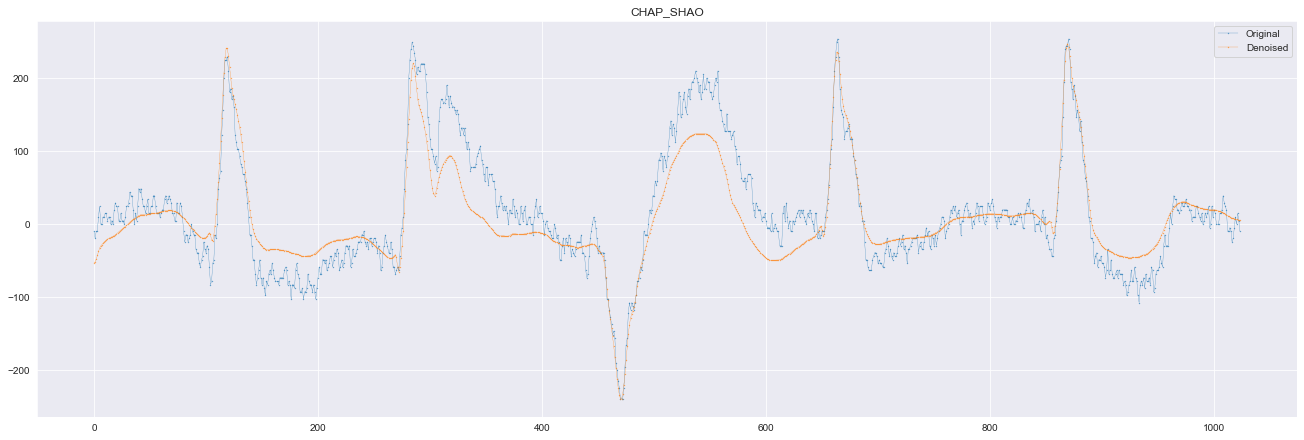

ic| dnm: 'CODE_TEST'
    fqs: 400
    sig.mean(): -0.4345287778542144
    denoised.mean(): 0.06772847781821077


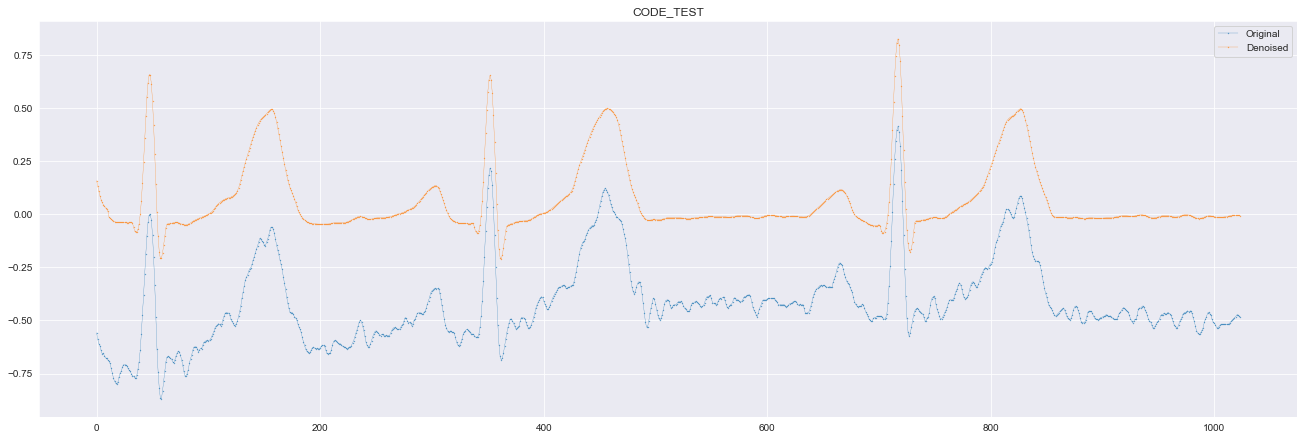

In [5]:
# denoised = dp.zheng(sig)
# plot_1d([sig, denoised], label=['Original', 'Zheng denoised'], e=2 ** 10)  # Doesn't look good?

for dnm, sig in d_eg.items():
    fqs = config(f'{DIR_DSET}.{dnm}.fqs')
    denoised = dp.zheng(sig)
    ic(dnm, fqs, sig.mean(), denoised.mean())
    plot_1d([sig, denoised], label=['Original', 'Denoised'], e=2 ** 10, title=dnm)



Looks like for those that don't have 500 fqs, the resulting ECG has an offset
=> Try resampling to 500Hz first?



ic| dnm: 'INCART'
    fqs: 257
    sig_.mean(): -10.266459882226236
    denoised.mean(): 0.005133185388661455


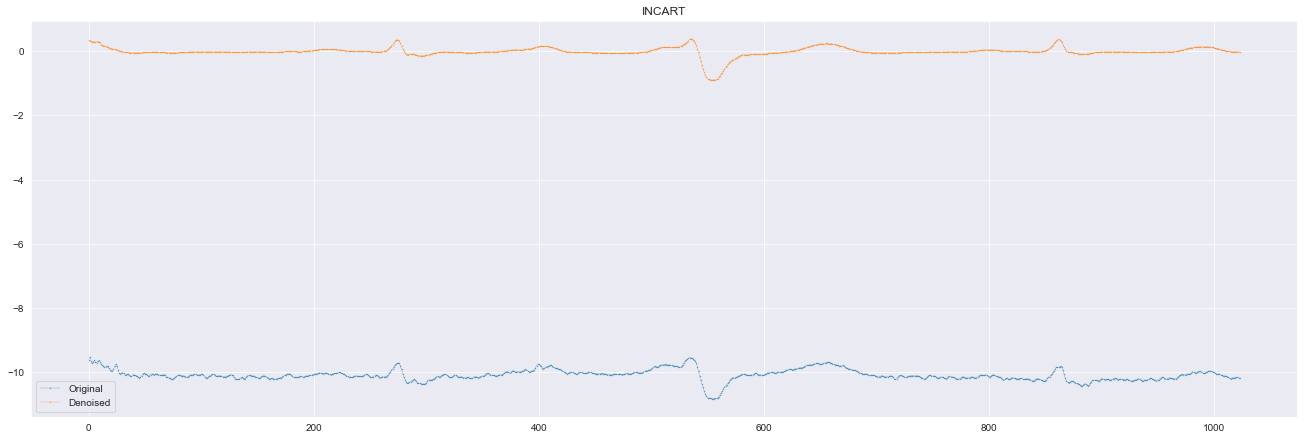

ic| dnm: 'PTB_Diagnostic'
    fqs: 1000
    sig_.mean(): -0.07147265625
    denoised.mean(): 0.0014429916709092412


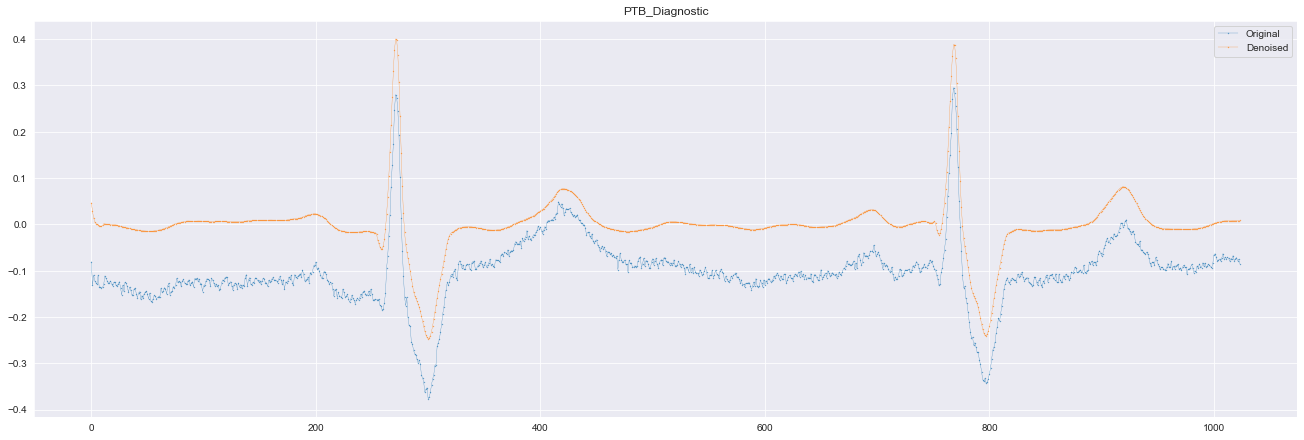

ic| dnm: 'CSPC_Extra_CinC'
    fqs: 500
    sig_.mean(): -0.0033632812500000004
    denoised.mean(): 0.000584333894140088


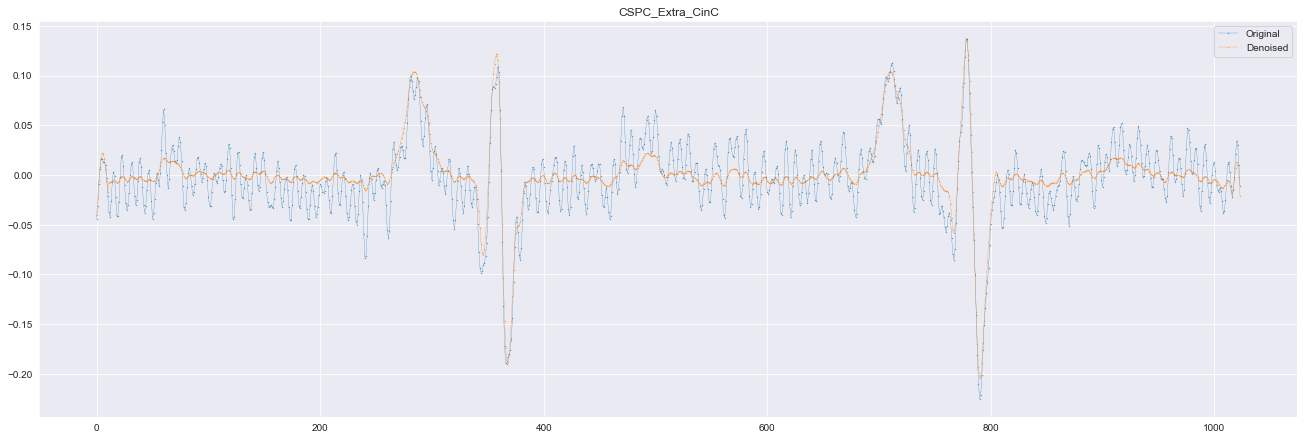

ic| dnm: 'CHAP_SHAO'
    fqs: 500
    sig_.mean(): 7.6440625
    denoised.mean(): 9.236300654930778


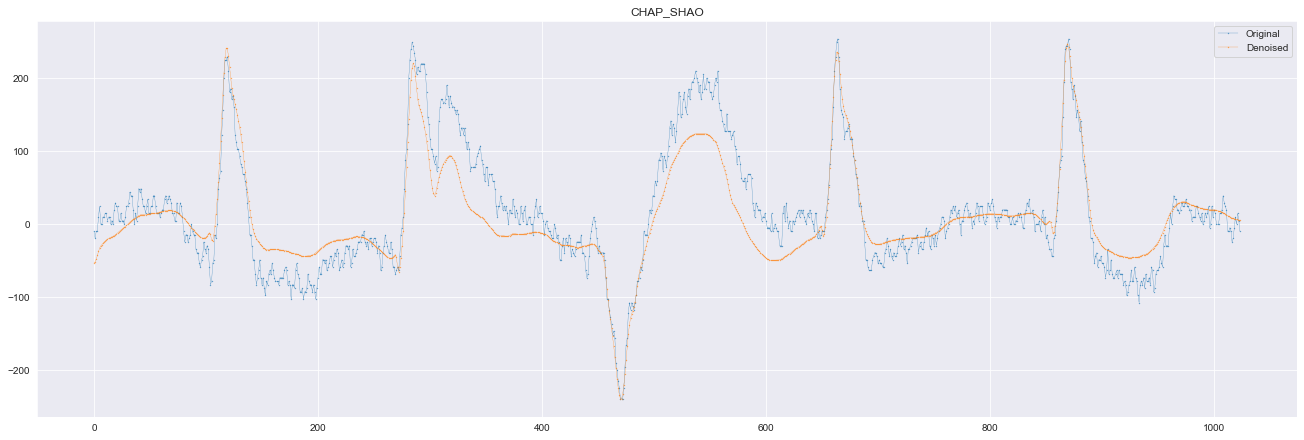

ic| dnm: 'CODE_TEST'
    fqs: 400
    sig_.mean(): -0.43452877785421434
    denoised.mean(): 0.05106625828422577


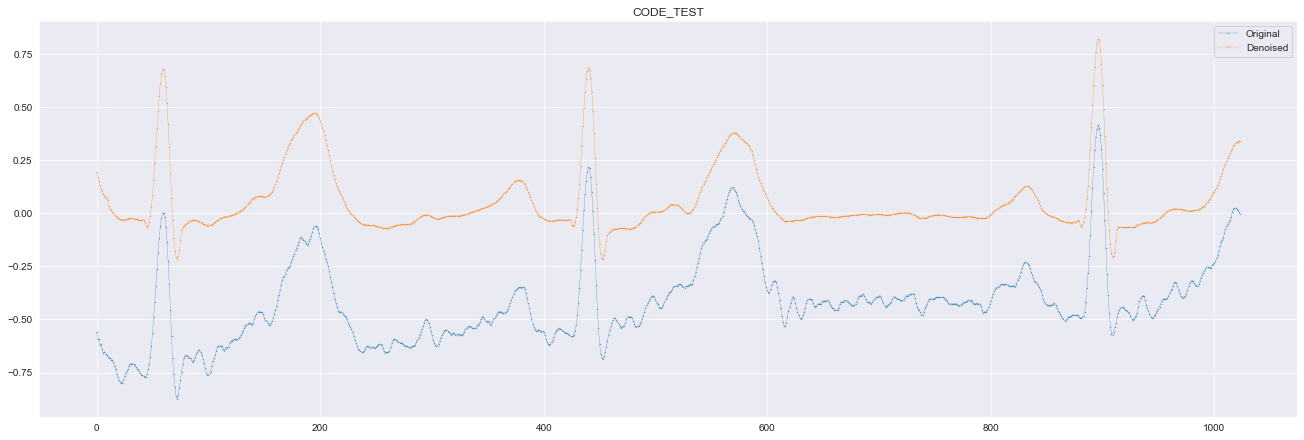

In [6]:
for dnm, sig in d_eg.items():
    fqs = config(f'{DIR_DSET}.{dnm}.fqs')
    sig_, _ = wfdb.processing.resample_sig(sig, fqs, 500)

    denoised = dp.zheng(sig_)
    ic(dnm, fqs, sig_.mean(), denoised.mean())
    plot_1d([sig_, denoised], label=['Original', 'Denoised'], e=2 ** 10, title=dnm)



### The resampled `INCART` looks different?
Cos the time points were different


ic| sig: array([ -9.59922179,  -9.6459144 ,  -9.6692607 , ..., -10.30933852,
                -10.29377432, -10.28988327])
    fqs: 257


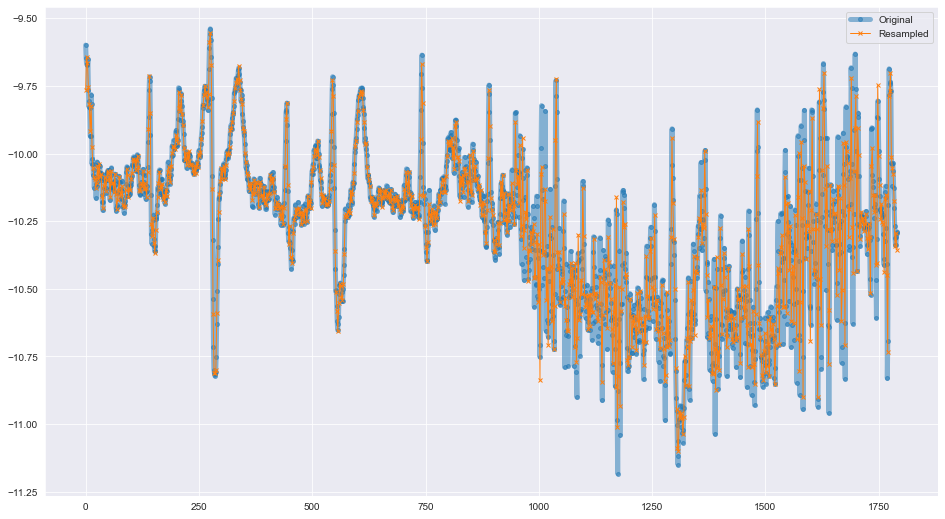

In [9]:
dnm = 'INCART'
sig = d_eg[dnm]
fqs = config(f'{DIR_DSET}.{dnm}.fqs')
ic(sig, fqs)
sig_resam, x_ = wfdb.processing.resample_sig(sig, fqs, 257 // 2)
# plot_1d([sig, sig_resam], label=['Original', 'Resampled'], e=2 ** 10, title=dnm)
plot_resampling(np.arange(sig.size), sig, x_, sig_resam)



### What's going on with the result of `CSPC_Extra_CinC`?
Is that huge fluctuation noise, or specific to that patient?
=> Try another signal


ic| sig: array([ 0.014,  0.012,  0.01 , ..., -0.007, -0.009, -0.012])
    fqs: 500
ic| dnm: 'CSPC_Extra_CinC'
    fqs: 500
    sig.mean(): -5.306319343947744e-06
    denoised.mean(): 0.014531562022407886


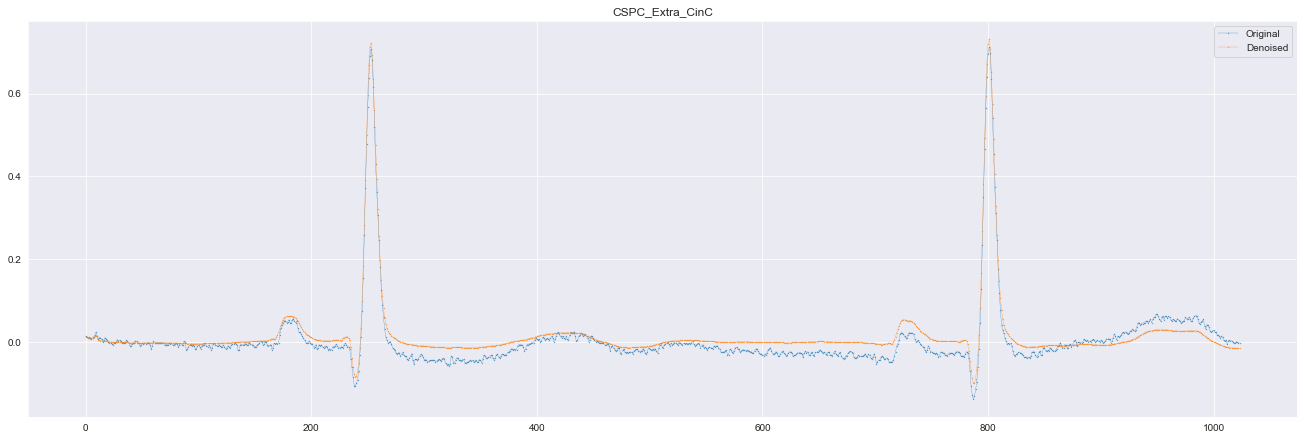

In [13]:
dnm = 'CSPC_Extra_CinC'
sig = get_signal_eg(dnm=dnm)[:, 0]
fqs = config(f'{DIR_DSET}.{dnm}.fqs')
ic(sig, fqs)
denoised = dp.zheng(sig)
ic(dnm, fqs, sig.mean(), denoised.mean())
plot_1d([sig, denoised], label=['Original', 'Denoised'], e=2 ** 10, title=dnm)

